<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
#!pip install --upgrade --no-cache-dir gdown --quiet

In [335]:
import gdown
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from keras_preprocessing.sequence import pad_sequences # se utilizará para padding
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.utils.np_utils import to_categorical
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [103]:
pd.set_option('display.max_columns', None)

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [4]:
# Descargar la carpeta de dataset

if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: c:\Users\Lucas Rivela\Desktop\rivela-nlp\Desafio_5\clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:02<00:00, 3.54MB/s]


In [6]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [7]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


<AxesSubplot:xlabel='Rating', ylabel='count'>

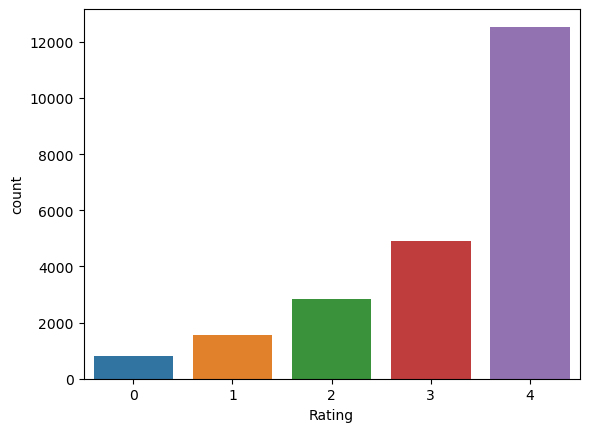

In [8]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
sns.countplot(x=df_reviews["Rating"])

In [9]:
df_reviews.Rating.value_counts(dropna=False)

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

In [132]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews_numpy = df_reviews["Review Text"].values

In [133]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
reviews_numpy.shape

(22641,)

In [134]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews_numpy)

In [135]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [136]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
tokens = text_to_word_sequence(corpus)

In [137]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [138]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

Saco stop words con NLTK

In [139]:
nltk_stop_words = set( stopwords.words("english") )
tokens = [w for w in tokens if w not in nltk_stop_words]
len(tokens)

670452

In [156]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=vocab_size) 
tok.fit_on_texts(tokens)

In [157]:
# Alumno: Obtener el diccionario de palabra (word) a índice y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14681

In [142]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(reviews_numpy)

In [143]:
sequences[0][:10]

[172, 427, 796, 550, 25]

In [144]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

63

In [145]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
maxlen = 63
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [146]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 63)

In [147]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews['Rating'].values
print(y.shape)

(22641,)


In [148]:
y

array([3, 4, 2, ..., 2, 2, 4], dtype=int64)

In [149]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y, num_classes=5)

In [150]:
print(y_data[0])

[0. 0. 0. 1. 0.]


In [215]:
# Alumno: Dividir los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.2, random_state=42)

In [216]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = y_data.shape[1]
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 63 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

Pruebo con embedding propio

In [159]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=5, input_length=in_shape))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(units=128))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 63, 5)             73410     
_________________________________________________________________
lstm_26 (LSTM)               (None, 63, 64)            17920     
_________________________________________________________________
dropout_26 (Dropout)         (None, 63, 64)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)               

In [160]:
hist = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 276s 604ms/step - loss: 1.0699 - accuracy: 0.5708 - val_loss: 0.9749 - val_accuracy: 0.5921
Epoch 2/50
453/453 [==============================] - 277s 611ms/step - loss: 0.8938 - accuracy: 0.6212 - val_loss: 0.9283 - val_accuracy: 0.6139
Epoch 3/50
453/453 [==============================] - 278s 614ms/step - loss: 0.8597 - accuracy: 0.6305 - val_loss: 0.9349 - val_accuracy: 0.6174
Epoch 4/50
453/453 [==============================] - 286s 631ms/step - loss: 0.8363 - accuracy: 0.6432 - val_loss: 0.9427 - val_accuracy: 0.6064
Epoch 5/50
453/453 [==============================] - 278s 613ms/step - loss: 0.8279 - accuracy: 0.6388 - val_loss: 0.9695 - val_accuracy: 0.6119
Epoch 6/50
453/453 [==============================] - 277s 612ms/step - loss: 0.8084 - accuracy: 0.6532 - val_loss: 0.9407 - val_accuracy: 0.6086
Epoch 7/50
453/453 [==============================] - 282s 622ms/step - loss: 0.7788 - accuracy: 0.6646 - val_loss: 0.9585 -

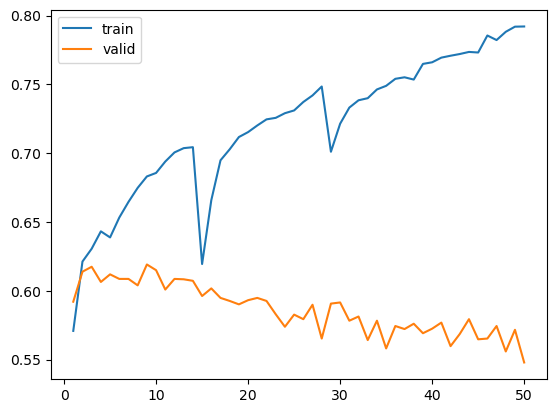

In [161]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [162]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

142/142 [==============================] - 13s 90ms/step - loss: 1.6908 - accuracy: 0.5699
Test loss: 1.6907932758331299
Test accuracy: 0.5698829889297485


Pruebo con embedding pre-entrenado

In [163]:
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download
To: c:\Users\Lucas Rivela\Desktop\rivela-nlp\Desafio_5\fasttext.pkl
100%|██████████| 2.88G/2.88G [14:24<00:00, 3.33MB/s]


In [165]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

In [166]:
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [167]:
model_fasttext = FasttextEmbeddings()

In [168]:
print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [193]:
# Definimos el modelo
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences
model2.add(Dense(units=128))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))
model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 63, 300)           600000    
_________________________________________________________________
lstm_38 (LSTM)               (None, 63, 64)            93440     
_________________________________________________________________
dropout_38 (Dropout)         (None, 63, 64)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_38 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 5)               

In [194]:
hist2 = model2.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 21s 37ms/step - loss: 1.2136 - accuracy: 0.5509 - val_loss: 1.2081 - val_accuracy: 0.5468
Epoch 2/50
453/453 [==============================] - 14s 31ms/step - loss: 1.1793 - accuracy: 0.5528 - val_loss: 1.1894 - val_accuracy: 0.5473
Epoch 3/50
453/453 [==============================] - 14s 32ms/step - loss: 1.1595 - accuracy: 0.5541 - val_loss: 1.1886 - val_accuracy: 0.5490
Epoch 4/50
453/453 [==============================] - 15s 33ms/step - loss: 1.1460 - accuracy: 0.5579 - val_loss: 1.1745 - val_accuracy: 0.5493
Epoch 5/50
453/453 [==============================] - 14s 31ms/step - loss: 1.1345 - accuracy: 0.5587 - val_loss: 1.1799 - val_accuracy: 0.5506
Epoch 6/50
453/453 [==============================] - 14s 31ms/step - loss: 1.1214 - accuracy: 0.5595 - val_loss: 1.1901 - val_accuracy: 0.5355
Epoch 7/50
453/453 [==============================] - 16s 34ms/step - loss: 1.1090 - accuracy: 0.5644 - val_loss: 1.1702 - val_accuracy:

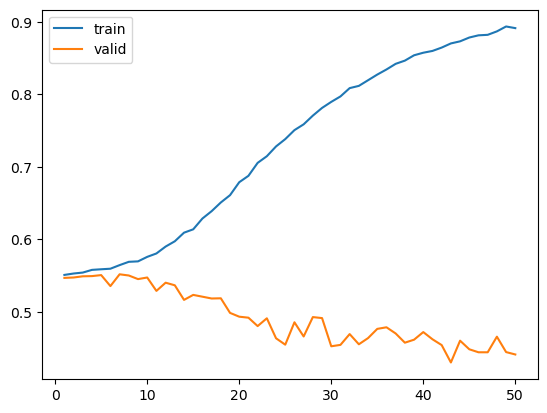

In [195]:
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [196]:
score = model2.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

142/142 [==============================] - 2s 16ms/step - loss: 2.9616 - accuracy: 0.4579
Test loss: 2.961575746536255
Test accuracy: 0.45793774724006653


Pruebo con balanceo de clases - pesos ponderados

In [271]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights

array([5.38246657, 2.92129032, 1.62076063, 0.91267322, 0.36242121])

In [272]:
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 5.382466567607727,
 1: 2.9212903225806452,
 2: 1.6207606263982104,
 3: 0.9126732174351222,
 4: 0.36242121060530263}

In [273]:
# Definimos el modelo
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences
model2.add(Dense(units=128))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))
model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 63, 300)           600000    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 63, 128)           186880    
_________________________________________________________________
dropout_62 (Dropout)         (None, 63, 128)           0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_62 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_63 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 5)               

In [274]:
hist3 = model2.fit(X_train, y_train, epochs=50, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/50
453/453 [==============================] - 55s 67ms/step - loss: 1.5870 - accuracy: 0.2857 - val_loss: 1.4147 - val_accuracy: 0.4725
Epoch 2/50
453/453 [==============================] - 28s 63ms/step - loss: 1.5452 - accuracy: 0.3407 - val_loss: 1.3302 - val_accuracy: 0.5068
Epoch 3/50
453/453 [==============================] - 28s 62ms/step - loss: 1.5304 - accuracy: 0.3466 - val_loss: 1.5757 - val_accuracy: 0.2967
Epoch 4/50
453/453 [==============================] - 28s 63ms/step - loss: 1.5118 - accuracy: 0.3716 - val_loss: 1.4739 - val_accuracy: 0.3806
Epoch 5/50
453/453 [==============================] - 29s 63ms/step - loss: 1.4973 - accuracy: 0.3855 - val_loss: 1.5049 - val_accuracy: 0.3464
Epoch 6/50
453/453 [==============================] - 29s 63ms/step - loss: 1.4848 - accuracy: 0.3802 - val_loss: 1.5088 - val_accuracy: 0.3354
Epoch 7/50
453/453 [==============================] - 28s 63ms/step - loss: 1.4663 - accuracy: 0.3919 - val_loss: 1.4156 - val_accuracy:

<AxesSubplot:>

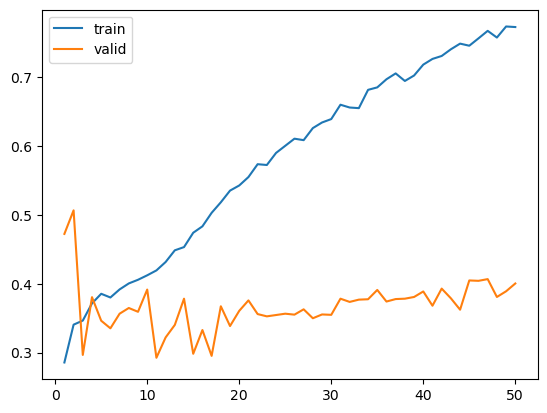

In [275]:
epoch_count = range(1, len(hist3.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist3.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist3.history['val_accuracy'], label='valid')

In [276]:
score = model2.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

142/142 [==============================] - 5s 32ms/step - loss: 2.7689 - accuracy: 0.4231
Test loss: 2.7688803672790527
Test accuracy: 0.4230514466762543


Pruebo con balanceo de clases - agrupar categorias

In [223]:
df_reviews["Rating"].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

Voy a agrupar las categorias 0, 1 y 2

In [224]:
def cambiar_rating(value):
    if value == 0 or value == 1 or value == 2:
        return 0
    elif value == 3:
        return 1
    else:
        return 2

In [225]:
df_reviews["Rating_Agrupado"] = df_reviews["Rating"].apply(lambda x: cambiar_rating(x))
df_reviews.head()

,Review Text,Rating,Rating_Agrupado
0,Absolutely wonderful - silky and sexy and comf...,3,1
1,Love this dress! it's sooo pretty. i happene...,4,2
2,I had such high hopes for this dress and reall...,2,0
3,"I love, love, love this jumpsuit. it's fun, fl...",4,2
4,This shirt is very flattering to all due to th...,4,2


In [226]:
df_reviews["Rating_Agrupado"].value_counts()

2    12540
0     5193
1     4908
Name: Rating_Agrupado, dtype: int64

In [251]:
y2 = df_reviews['Rating_Agrupado'].values

y_data2 = to_categorical(y2, num_classes=3)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_data2, test_size=0.2, random_state=42)

undersampler = RandomUnderSampler(random_state=42)

X_train_us, y_train_us = undersampler.fit_resample(X_train2, y_train2)

In [252]:
np.unique(y_train2, return_counts=True, axis=0)

(array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=float32),
 array([9995, 3969, 4148], dtype=int64))

In [253]:
np.unique(y_train_us, return_counts=True, axis=0)

(array([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]]),
 array([3969, 3969, 3969], dtype=int64))

In [256]:
# Definimos el modelo
model3 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model3.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model3.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences
model3.add(Dense(units=128))
model3.add(Dropout(rate=0.2))
model3.add(Dense(units=3, activation='softmax'))
model3.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 63, 300)           600000    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 63, 128)           186880    
_________________________________________________________________
dropout_56 (Dropout)         (None, 63, 128)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_56 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_57 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 3)               

In [257]:
hist4 = model3.fit(X_train2, y_train2, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 38s 67ms/step - loss: 0.9803 - accuracy: 0.5559 - val_loss: 0.9547 - val_accuracy: 0.5672
Epoch 2/50
453/453 [==============================] - 29s 64ms/step - loss: 0.9513 - accuracy: 0.5723 - val_loss: 0.9488 - val_accuracy: 0.5785
Epoch 3/50
453/453 [==============================] - 29s 64ms/step - loss: 0.9332 - accuracy: 0.5807 - val_loss: 0.9436 - val_accuracy: 0.5791
Epoch 4/50
453/453 [==============================] - 29s 64ms/step - loss: 0.9187 - accuracy: 0.5855 - val_loss: 0.9345 - val_accuracy: 0.5857
Epoch 5/50
453/453 [==============================] - 29s 64ms/step - loss: 0.9116 - accuracy: 0.5875 - val_loss: 0.9466 - val_accuracy: 0.5929
Epoch 6/50
453/453 [==============================] - 29s 64ms/step - loss: 0.9015 - accuracy: 0.5967 - val_loss: 0.9309 - val_accuracy: 0.5829
Epoch 7/50
453/453 [==============================] - 29s 65ms/step - loss: 0.8876 - accuracy: 0.5973 - val_loss: 0.9265 - val_accuracy:

<AxesSubplot:>

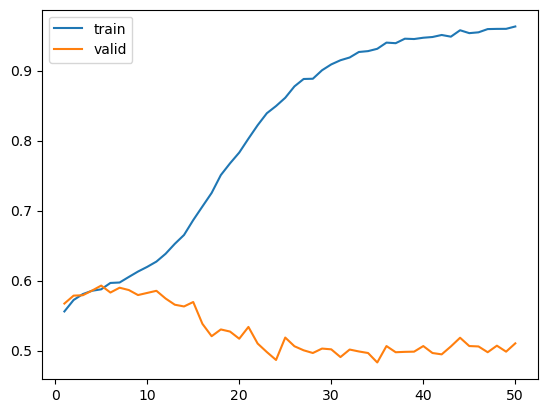

In [258]:
epoch_count = range(1, len(hist4.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist4.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist4.history['val_accuracy'], label='valid')

In [260]:
score = model3.evaluate(X_test2, y_test2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

142/142 [==============================] - 5s 33ms/step - loss: 3.3241 - accuracy: 0.5401
Test loss: 3.324080228805542
Test accuracy: 0.5400750637054443


Pruebo con balanceo de clases con embedding propio

In [263]:
model4 = Sequential()
model4.add(Embedding(input_dim=len(word_index)+1, output_dim=5, input_length=in_shape))
model4.add(LSTM(64, activation='relu', return_sequences=True))
model4.add(Dropout(0.2))
model4.add(LSTM(64, activation='relu'))
model4.add(Dense(units=128))
model4.add(Dropout(rate=0.2))
model4.add(Dense(units=3, activation='softmax'))
model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 63, 5)             73410     
_________________________________________________________________
lstm_62 (LSTM)               (None, 63, 64)            17920     
_________________________________________________________________
dropout_60 (Dropout)         (None, 63, 64)            0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_60 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_61 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 3)               

In [264]:
hist5 = model4.fit(X_train2, y_train2, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 285s 622ms/step - loss: 0.8257 - accuracy: 0.6328 - val_loss: 0.7187 - val_accuracy: 0.7008
Epoch 2/50
453/453 [==============================] - 276s 609ms/step - loss: 0.6724 - accuracy: 0.7087 - val_loss: 0.7138 - val_accuracy: 0.6939
Epoch 3/50
453/453 [==============================] - 278s 615ms/step - loss: 0.6416 - accuracy: 0.7225 - val_loss: 0.7038 - val_accuracy: 0.7069
Epoch 4/50
453/453 [==============================] - 277s 612ms/step - loss: 0.6260 - accuracy: 0.7301 - val_loss: 0.7199 - val_accuracy: 0.6991
Epoch 5/50
453/453 [==============================] - 279s 615ms/step - loss: 0.6077 - accuracy: 0.7391 - val_loss: 0.7088 - val_accuracy: 0.7011
Epoch 6/50
453/453 [==============================] - 277s 612ms/step - loss: 0.5975 - accuracy: 0.7438 - val_loss: 0.7319 - val_accuracy: 0.6936
Epoch 7/50
453/453 [==============================] - 275s 606ms/step - loss: 0.5832 - accuracy: 0.7497 - val_loss: 0.7365 -

<AxesSubplot:>

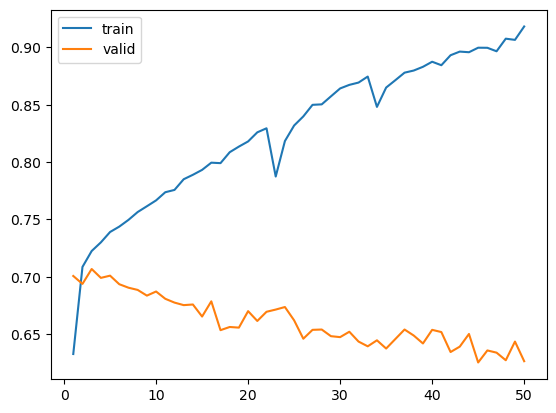

In [265]:
epoch_count = range(1, len(hist5.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist5.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist5.history['val_accuracy'], label='valid')

In [266]:
score = model4.evaluate(X_test2, y_test2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

142/142 [==============================] - 14s 97ms/step - loss: 2.9025 - accuracy: 0.6383
Test loss: 2.902461290359497
Test accuracy: 0.6383307576179504


##### Pruebo con lemmatization

In [342]:
# Crear el lematizador
lemmatizer = WordNetLemmatizer()

# Transformar los tokens a sus respectivas palabras raiz - Lemmatization
nltk_lemmaList = []
for word in tokens:
    word, tag = pos_tag([word])[0]
    wntag = tag[0].lower()
    wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    if not wntag:
        lemma = word
    else:
        lemma = lemmatizer.lemmatize(word, wntag)
    
    nltk_lemmaList.append(lemma)

In [343]:
nltk_lemmaList[:10]

['absolutely',
 'wonderful',
 'silky',
 'sexy',
 'comfortable',
 'love',
 'dress',
 'sooo',
 'pretty',
 'happen']

In [344]:
tok2 = Tokenizer(num_words=vocab_size) 
tok2.fit_on_texts(nltk_lemmaList)

word_index2 = tok2.word_index
len(word_index2)

11938

In [347]:
#reviews_numpy_lemma = [[lemmatizer.lemmatize(word) for word in text_to_word_sequence(review) ] for review in reviews_numpy]
reviews_numpy_lemma = []
for review in reviews_numpy:
    string_ = ""
    for word in text_to_word_sequence(review):
        word, tag = pos_tag([word])[0]
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            string_ += word
        else:
            string_ += lemmatizer.lemmatize(word, wntag)
        string_ += " "
    reviews_numpy_lemma.append(string_)

In [293]:
reviews_numpy[:5]

array(['Absolutely wonderful - silky and sexy and comfortable',
       'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
       'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
       "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothi

In [348]:
reviews_numpy_lemma[:5]

['absolutely wonderful silky and sexy and comfortable ',
 "love this dress it's sooo pretty i happen to find it in a store and i'm glad i do bc i never would have order it online bc it's petite i bought a petite and be 5'8 i love the length on me hit just a little below the knee would definitely be a true midi on someone who be truly petite ",
 'i have such high hope for this dress and really want it to work for me i initially order the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reorder it in petite medium which be just ok overall the top half be comfortable and fit nicely but the bottom half have a very tight under layer and several somewhat cheap net over layer imo a major design flaw be the net over layer sewn directly into the zipper it c ',
 "i love love love this jumpsuit it's fun flirty and fabulous every time i wear it i get nothing but great compliment ",
 'this shirt be very flatter to all due to the adju

In [349]:
# Convertir las palabras/tokens a números
sequences2 = tok2.texts_to_sequences(reviews_numpy_lemma)

In [350]:
sequences2[0][:10]

[174, 399, 747, 509, 30]

In [351]:
max(len(s) for s in sequences2)

63

In [352]:
X2 = pad_sequences(sequences2, padding='pre', maxlen=63)

In [353]:
X2.shape

(22641, 63)

Con las categorias agrupadas en 0, 1 y 2

In [354]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X2, y_data2, test_size=0.2, random_state=42)

In [359]:
model_fasttext = FasttextEmbeddings()

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

nb_words = min(num_words, len(word_index2)) # vocab_size
embedding_matrix2 = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix2[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix2**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [361]:
# Definimos el modelo
model5 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model5.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=63, # máxima sentencia de entrada
                     weights=[embedding_matrix2], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model5.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model5.add(Dropout(0.2))
model5.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences
model5.add(Dense(units=128))
model5.add(Dropout(rate=0.2))
model5.add(Dense(units=3, activation='softmax'))
model5.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 63, 300)           600000    
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 63, 128)           186880    
_________________________________________________________________
dropout_72 (Dropout)         (None, 63, 128)           0         
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_72 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_73 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 3)               

In [362]:
hist6 = model5.fit(X_train_lem, y_train_lem, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 88s 68ms/step - loss: 0.9722 - accuracy: 0.5626 - val_loss: 0.9673 - val_accuracy: 0.5573
Epoch 2/50
453/453 [==============================] - 29s 63ms/step - loss: 0.9460 - accuracy: 0.5757 - val_loss: 0.9619 - val_accuracy: 0.5633
Epoch 3/50
453/453 [==============================] - 28s 63ms/step - loss: 0.9380 - accuracy: 0.5768 - val_loss: 0.9619 - val_accuracy: 0.5716
Epoch 4/50
453/453 [==============================] - 29s 63ms/step - loss: 0.9296 - accuracy: 0.5784 - val_loss: 0.9538 - val_accuracy: 0.5614
Epoch 5/50
453/453 [==============================] - 29s 63ms/step - loss: 0.9237 - accuracy: 0.5839 - val_loss: 0.9499 - val_accuracy: 0.5725
Epoch 6/50
453/453 [==============================] - 29s 63ms/step - loss: 0.9147 - accuracy: 0.5830 - val_loss: 0.9543 - val_accuracy: 0.5758
Epoch 7/50
453/453 [==============================] - 29s 63ms/step - loss: 0.9074 - accuracy: 0.5890 - val_loss: 0.9377 - val_accuracy:

<AxesSubplot:>

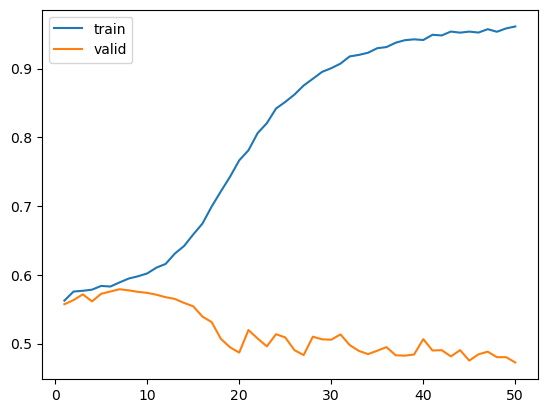

In [363]:
epoch_count = range(1, len(hist6.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist6.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist6.history['val_accuracy'], label='valid')

In [368]:
score = model5.evaluate(X_test_lem, y_test_lem)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

142/142 [==============================] - 5s 34ms/step - loss: 3.5502 - accuracy: 0.4895
Test loss: 3.550204277038574
Test accuracy: 0.48951202630996704


Pruebo lemmatization y embeddings propios

In [369]:
model6 = Sequential()
model6.add(Embedding(input_dim=len(word_index)+1, output_dim=5, input_length=in_shape))
model6.add(LSTM(64, activation='relu', return_sequences=True))
model6.add(Dropout(0.2))
model6.add(LSTM(64, activation='relu'))
model6.add(Dense(units=128))
model6.add(Dropout(rate=0.2))
model6.add(Dense(units=3, activation='softmax'))
model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model6.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 63, 5)             73410     
_________________________________________________________________
lstm_76 (LSTM)               (None, 63, 64)            17920     
_________________________________________________________________
dropout_74 (Dropout)         (None, 63, 64)            0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_74 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_75 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 3)               

In [372]:
hist7 = model6.fit(X_train_lem, y_train_lem, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 280s 609ms/step - loss: 0.8330 - accuracy: 0.6297 - val_loss: 0.7252 - val_accuracy: 0.6898
Epoch 2/50
453/453 [==============================] - 276s 610ms/step - loss: 0.6840 - accuracy: 0.7054 - val_loss: 0.6982 - val_accuracy: 0.7060
Epoch 3/50
453/453 [==============================] - 296s 653ms/step - loss: 0.6529 - accuracy: 0.7178 - val_loss: 0.7152 - val_accuracy: 0.6972
Epoch 4/50
453/453 [==============================] - 294s 650ms/step - loss: 0.6349 - accuracy: 0.7234 - val_loss: 0.7246 - val_accuracy: 0.6936
Epoch 5/50
453/453 [==============================] - 278s 614ms/step - loss: 0.6232 - accuracy: 0.7290 - val_loss: 0.7239 - val_accuracy: 0.6972
Epoch 6/50
453/453 [==============================] - 281s 620ms/step - loss: 0.6120 - accuracy: 0.7350 - val_loss: 0.7240 - val_accuracy: 0.6958
Epoch 7/50
453/453 [==============================] - 276s 609ms/step - loss: 0.6007 - accuracy: 0.7424 - val_loss: 0.7279 -

<AxesSubplot:>

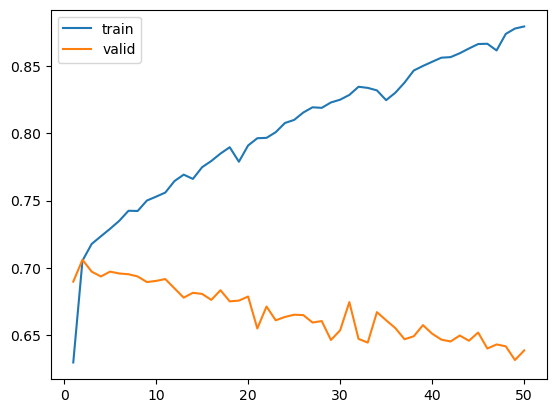

In [373]:
epoch_count = range(1, len(hist7.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist7.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist7.history['val_accuracy'], label='valid')

In [374]:
score = model6.evaluate(X_test_lem, y_test_lem)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

142/142 [==============================] - 12s 68ms/step - loss: 1.5955 - accuracy: 0.6476
Test loss: 1.5955297946929932
Test accuracy: 0.6476043462753296


#### Conclusiones

<table>
  <tr>
    <th>Tipo de Prueba</th>
    <th>Puntaje en Test</th>
  </tr>
  <tr>
    <td>Embedding Propio - Sin Stop Words y sin balanceo</td>
    <td>0.57</td>
  </tr>
  <tr>
    <td>Embedding Pre Entrenado - Sin Stop Words y sin balanceo</td>
    <td>0.53</td>
  </tr>
  <tr>
    <td>Embedding Pre Entrenado - Sin Stop Words + Pesos Ponderados</td>
    <td>0.42</td>
  </tr>
  <tr>
    <td>Embedding Pre Entrenado - Sin Stop Words + Categorias Agrupadas</td>
    <td>0.54</td>
  </tr>
  <tr>
    <td>Embedding Propio - Sin Stop Words + Categorias Agrupadas</td>
    <td>0.64</td>
  </tr>
  <tr>
    <td>Embedding Pre Entrenado - Sin Stop Words + Lemmatization + Categorias Agrupadas</td>
    <td>0.49</td>
  </tr>
  <tr>
    <td>Embedding Propio - Sin Stop Words + Lemmatization + Categorias Agrupadas</td>
    <td>0.65</td>
  </tr>
</table>

En todas las pruebas realizadas no se ha podido evitar el overfitting. Por otro lado, utilizar un Embedding propio siempre ha dado un mejor accuracy en test.